### Project: Application of BERT to Electronic Health Records to predit the next diagnosis

In [1]:
local_mode = False


In [15]:
if not local_mode:
  !mkdir commons
  !wget -P commons https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/commons/utils.py
  !wget -P commons https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/commons/__init__.py

  !mkdir data
  !wget -P data https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/data/ages.pkl
  !wget -P data https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/data/concept.pkl
  !wget -P data https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/data/condition_codes.pkl
  !wget -P data https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/data/conditions.pkl

  !mkdir saved_models


--2023-04-22 20:48:43--  https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/commons/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10650 (10K) [text/plain]
Saving to: ‘commons1/utils.py’

utils.py            100%[===================>]  10.40K  --.-KB/s    in 0s      

2023-04-22 20:48:43 (115 MB/s) - ‘commons1/utils.py’ saved [10650/10650]

--2023-04-22 20:48:43--  https://raw.githubusercontent.com/bdigafe/cs598_dlh_final/master/behrt/commons/__init__.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [2]:
if not local_mode:
    from google.colab import drive
    drive.mount('/content/gdrive')

    !cp -r gdrive/MyDrive/behrt/data/ data/
    !cp -r gdrive/MyDrive/behrt/commons/ commons/
    !cp -r gdrive/MyDrive/behrt/models/ models/

Mounted at /content/gdrive


In [16]:
import os
import pdb
import sys
import time
import pickle
import random
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import commons.utils as utils

# set random seed for reproducibility
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
os.environ['PYTHONASHSEED'] = str(seed)

global_params = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'max_seq_len': 256,
    'max_age' : 110,
    'age_month' : 1,
    'min_visit': 5,

    'batch_size': 128,
    'num_epochs': 10,
    'gradient_accumulation_steps': 1,
    'training_sample': 0,
    
    # Bert model parameters to fine-tune
    'attention_heads': 12,
    'num_hidden_layers': 6,
    'hidden_size': 288
}

optim_param = {
    'lr': 3e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

file_config = {
    'vocab': ('C:/Birhanu/Education/UIL/cs598/Final/data/' if local_mode else 'data/') + 'condition_codes.pkl',
    'data': ('C:/Birhanu/Education/UIL/cs598/Final/data/' if local_mode else 'data/') + 'conditions.pkl',
    'ages': ('C:/Birhanu/Education/UIL/cs598/Final/data/' if local_mode else 'data/') + 'ages.pkl',
    
    'model_path': 'C:/Birhanu/Education/UIL/cs598/Final/saved_models/' if local_mode else 'data/',  # where to save model
    'model_name': 'mlm128',  # model name
    'log_file_name': 'log',  # log path
}


In [19]:
print(global_params["device"])

cuda


In [20]:
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

#### Load pre-processed data
Data has been pre-processed and saved as pkl file.

- conditions_seqs = [pid, [conditions]]
- condition_codes = [code, frequency_count]
- ages = [pid, [age for each condition]]

In [21]:
# Load pickle files
conditions_seqs = pickle.load(open(file_config["data"], 'rb'))
age_seqs = pickle.load(open(file_config["ages"], 'rb'))
condition_codes = pickle.load(open(file_config["vocab"], 'rb'))

print(f"Condition sequences: \n{conditions_seqs.head()}")
print(f"Age sequences:\n{age_seqs.head()}")
print(f"Condition codes:\n{condition_codes.head()}")

# convert to numpy array
conditions_seqs = np.array(conditions_seqs["conditions"])
age_seqs = np.array(age_seqs["ages"])

# Keep only a small size for training
if (global_params["training_sample"] > 0):
    conditions_seqs = conditions_seqs[:global_params["training_sample"]]
    age_seqs = age_seqs[:global_params["training_sample"]]


Condition sequences: 
      pid                                         conditions
0  176101  [1572199, SEP, 35207924, SEP, 35209141, SEP, 1...
1  176102  [35207924, 35211387, SEP, 1569634, SEP, 157606...
2  176103  [1570669, SEP, 1570669, SEP, 35208969, SEP, 35...
3  176104  [35208969, SEP, 35208968, 35208969, SEP, 35208...
4  176105  [1568078, 1569178, 1572190, 1572239, SEP, 1568...
Age sequences:
      pid                                               ages
0  176101  [947, 947, 947, 947, 949, 949, 949, 949, 949, ...
1  176102  [230, 230, 230, 262, 262, 263, 263, 267, 267, ...
2  176103           [664, 664, 666, 666, 672, 672, 684, 684]
3  176104  [623, 623, 623, 623, 623, 623, 623, 623, 625, ...
4  176105  [683, 683, 683, 683, 683, 684, 684, 684, 689, ...
Condition codes:
  condition                                     condition_name  counts
0     10851  Sprain of joints and ligaments of other parts ...    4323
1     11803                Sprain of ligaments of lumbar spine    4293
2

In [22]:
# Get the max number of visits per patient for all patients
max_code_seqs = np.max([len(seq) for seq in conditions_seqs])
max_age_seqs = np.max([len(seq) for seq in age_seqs])

# Inspect sequence data
print(f"Number of patients: {len(conditions_seqs)}")
print(f"Max number of code sequences: {max_code_seqs}")
print(f"Max number of age sequences: {max_age_seqs}")



Number of patients: 54498
Max number of code sequences: 447
Max number of age sequences: 447


#### Build ageVocab
This allows conversion between a person's age to an index or an index to age.

In [23]:
age2idx, idx2age = utils.age_vocab(max_age=110, mon=global_params["age_month"])

ageVocab = {
    'token2idx': age2idx,
    'idx2token': idx2age
}

assert ageVocab['token2idx']["30"] == 32
assert ageVocab['idx2token'][30] == "28"

#### Build code from/to index vocab for condition codes
The vocab will be used to convert from/to condition codes and indexes.
All the diagnosis codes are loaded from the diag_codes.pkl file.

In [24]:
conditionsVocab = utils.get_codes_vocab(file_config['vocab'])

print(conditionsVocab['idx2token'][5])

assert conditionsVocab['idx2token'][5] == "10851"
assert conditionsVocab['token2idx']["10851"] == 5


10851


### View distribution of condition codes.
We removed conditions with less than 3000 ocurrences but it is good to see the prevalence of the remaining conditions.

In [25]:
if not local_mode:
    %pip install mplcursors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mplcursors: filename=mplcursors-0.5.2-py3-none-any.whl size=21071 sha256=b9afc8d61e00e8feb8ab68e97f77df056d3f1a53a0b28c60548aeb498634415b
  Stored in directory: /root/.cache/pip/wheels/b1/98/ff/4885c231adf3d185efdc38cf8aa2527f1b255ca714a43cb125
Successfully built mplcursors


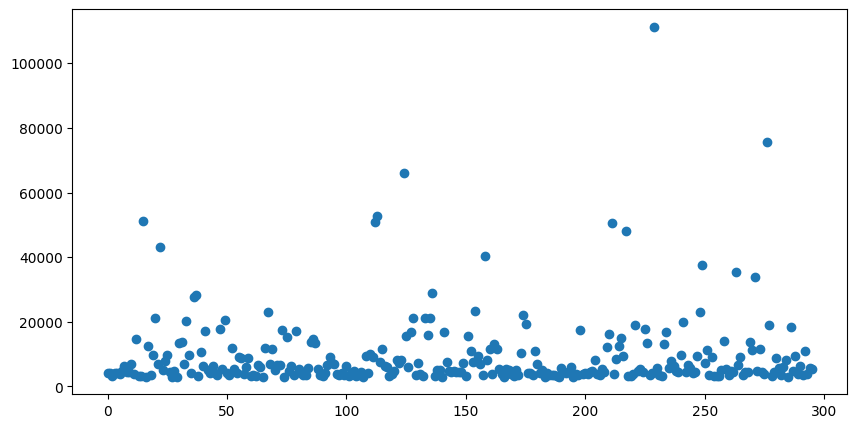

In [26]:
from matplotlib import pyplot as plt
import mplcursors

fig, ax = plt.subplots(figsize=(10, 5))
scatter = ax.scatter(condition_codes.index, condition_codes["counts"])

mplcursor = mplcursors.cursor(scatter, hover=True)
mplcursor.connect("add", lambda sel: sel.annotation.set_text(
    condition_codes[sel.target.index]["condition"]))


plt.show()


### Create a collate function to flatten the diagnosis codes

The seqs data has the following format: 
[pid, vid, [diagnosis codes]]

In [27]:
class Collator:

    def __call__(self, data):
        """
            Arguments:
                data: a list of samples fetched from 'MLMDataset'

            Outputs:
                code_seqs: a tensor of shape (# patients, len(condition_codes))
                age_seqs: A tensor of shape(# patients, max_age)
        """
        pass

collate_fn = Collator()


### Define custom dataset

In [28]:
from torch.utils.data.dataset import Dataset
import numpy as np
import torch


class MLMDataset(Dataset):
    """
        Dataloader for MLM task. 
        The input is a list of tokens specified by datafrmae and the output is a list of tokens with masking.
        The output is used to train the model to predict the masked tokens.

        The dataloaer will return the following:
            code: list = list of tokens
            age: list = list of age of the patient
           
            position: list = list of position indexes
            segmentation: list = list of segment indexes
            mask: list = list of mask indexes  (1 indicate the token is masked)
            label: list = list of label indexes (the label is the index of the token in the original tokens)

        the input dataframe must have the following columns:
            code: list = list of tokens
            age: list = list of age of the patient

    """

    def __init__(self, code_seqs, age_seqs, token2idx, age2idx, max_len, code='code', age='age'):
        self.max_len = max_len

        self.code_seqs = code_seqs
        self.age_seqs = age_seqs

        self.token2idx = token2idx
        self.age2idx = age2idx

    def __getitem__(self, index):
        """
        return: age, code, position, segmentation, mask, label
        """

        # extract data
        code_tokens = self.code_seqs[index][(-self.max_len+1):]
        age_tokens = self.age_seqs[index][(-self.max_len+1):]

        # avoid data cut with first element to be 'SEP'
        if code_tokens[0] != 'CLS':
            code_tokens = np.append(np.array(['CLS']), code_tokens)
            age_tokens = np.append(age_tokens[0], age_tokens)

        # mask 0:len(code) to 1, padding to be 0
        mask = np.ones(self.max_len)
        mask[len(code_tokens):] = 0
        num_tokens = len(code_tokens)

        # Get index for Unknown symbol and Pad symbol
        pad_symbol = self.token2idx.get('PAD')

        # Pad age sequences
        age_tokens = utils.seq_padding(age_tokens, self.max_len, token2idx=self.age2idx)

        # Masking: get masked code and label. Token -> Index
        out_tokens, label = utils.random_mask(code_tokens, token2idx=self.token2idx)
        code_tokens = utils.seq_padding(code_tokens, self.max_len)

        # get the number of masked tokens
        #n_mask = (torch.tensor(label) != -1).sum().item()
        #print(f"Index: {index}, Total: {num_tokens}, Masked tokens: {n_mask}, Percentage: {n_mask/num_tokens*100:.2f}%")

        # Additinal embeddings Position and Segment)
        position = utils.position_idx(code_tokens)
        segment = utils.index_seg(code_tokens)

        # Pad tokens and lables
        out_tokens = utils.seq_padding(out_tokens, self.max_len, symbol=pad_symbol)
        label = utils.seq_padding(label, self.max_len, symbol=-1)     

        return  torch.LongTensor(out_tokens), \
                torch.LongTensor(age_tokens), \
                torch.LongTensor(position), \
                torch.LongTensor(segment), \
                torch.LongTensor(mask), \
                torch.LongTensor(label)

    def __len__(self):
        return len(self.code_seqs)


In [29]:

token2idx = conditionsVocab["token2idx"]
age2idx = ageVocab["token2idx"]

dataset = MLMDataset(conditions_seqs, age_seqs, token2idx,age2idx, max_len=global_params['max_seq_len'])

print(f"Length dataset: {len(dataset)}\n")

if (global_params["training_sample"] > 0):
    assert len(
        dataset) == global_params["training_sample"], "The number of records is not correct"
else:
    assert len(dataset) == 54498, "The number of records is not correct"

print(conditionsVocab["idx2token"][4])

Length dataset: 54498

UNK


In [30]:
# Test batch data
from torch.utils.data import DataLoader

def inspect_batch():
    dataset = MLMDataset(conditions_seqs, age_seqs, token2idx, age2idx, max_len=global_params['max_seq_len'])
    train_loader = DataLoader(dataset=dataset, batch_size=global_params['batch_size'], shuffle=False)
    loader_iter = iter(train_loader)
    batch = next(loader_iter)

    batch = tuple(t.to(global_params['device']) for t in batch)
    input_ids, age_ids, posi_ids, segment_ids, attMask, masked_label = batch
    
    # Token codes
    p = 10
    print(f"Input:\n {input_ids[p, 0:20]}\n")
    print(f"Age:\n{age_ids[p, 0:20]}\n")
    print(f"Positions:\n{posi_ids[p, 0:20]}\n")
    print(f"Segments:\n{segment_ids[p, 0:20]}\n")

    print(attMask[p, 0:10])
    print(masked_label[p, 0:10])

    # Coditions vocab
    for i in range(5):
      print(f"{i} == {conditionsVocab['idx2token'][i]}")

    # Display input ids for the 2nd record in the batch
    print(input_ids[1, 0:10])

inspect_batch()
     

Input:
 tensor([  0, 254,   1, 133,   1,   3,   1, 133,   1, 133,   1, 133,   1, 133,
          1, 133, 292,   1, 116, 133], device='cuda:0')

Age:
tensor([397, 397, 397, 411, 411, 412, 412, 412, 412, 412, 412, 412, 412, 412,
        412, 412, 412, 412, 412, 412], device='cuda:0')

Positions:
tensor([0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 7, 8, 8],
       device='cuda:0')

Segments:
tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0],
       device='cuda:0')

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([ -1,  -1,  -1,  -1,  -1, 133,  -1,  -1,  -1,  -1], device='cuda:0')
0 == CLS
1 == SEP
2 == PAD
3 == MASK
4 == UNK
tensor([  0,   3, 275,   3,  96,   1, 203,   3,  78, 163], device='cuda:0')


In [31]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=dataset, batch_size=global_params['batch_size'], shuffle=True)

loader_iter = iter(train_loader)
code_tokens, age_tokens, position, segment, mask, label = next(loader_iter)

assert code_tokens.shape == (global_params['batch_size'], global_params['max_seq_len'])
assert age_tokens.shape == (global_params['batch_size'], global_params['max_seq_len'])
assert position.shape == (global_params['batch_size'], global_params['max_seq_len'])
assert segment.shape == (global_params['batch_size'], global_params['max_seq_len'])


### Pre-taining BEHRT

##### Define BERT model configuration

In [32]:
model_config = {
    # number of disease + symbols for word embedding
    'vocab_size': len(conditionsVocab['token2idx'].keys()),

    # word embedding and seg embedding hidden size  
    'hidden_size': global_params['hidden_size'],

    # number of vocab for seg embedding
    'seg_vocab_size': 2,  

    # number of vocab for age embedding
    'age_vocab_size': len(ageVocab['token2idx'].keys()),
    
    # maximum number of tokens
    'max_position_embedding': global_params['max_seq_len'],

    # dropout rate
    'hidden_dropout_prob': 0.1, 

    # number of multi-head attention layers required
    'num_hidden_layers': global_params['num_hidden_layers'] ,  

    # number of attention heads
    'num_attention_heads': global_params['attention_heads'], 

    # multi-head attention dropout rate
    'attention_probs_dropout_prob': 0.1,  

    # the size of the "intermediate" layer in the transformer encoder
    'intermediate_size': 512,

    # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'hidden_act': 'gelu',

    # The layer normalization epsilon
    'initializer_range': 0.02, 
}

In [33]:
if not local_mode:
    %pip install pytorch_pretrained_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 11.9 MB/s eta 0:00:00


In [34]:
import models
import pytorch_pretrained_bert as Bert
import sklearn.metrics as skm

import models.BertConfig as BertConfig
import models.MLM as MLM
from models.optimizer import adam

conf = BertConfig.BertConfig(model_config)
model = MLM.BertForMaskedLM(conf)
model

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 4488397


In [35]:
model = model.to(global_params['device'])
optim = adam(params=list(model.named_parameters()), config=optim_param)


In [36]:
def cal_acc(label, pred):
    logs = nn.LogSoftmax()
    
    label = label.cpu().numpy()

    # Exclude tokens that were not masked
    ind = np.where(label != -1)[0]

    # Get True label
    truelabel = label[ind]

    # Get the true prediction
    truepred = pred.detach().cpu().numpy()
    truepred = truepred[ind]
    truepred = logs(torch.tensor(truepred))
    outs = [np.argmax(pred_x) for pred_x in truepred.numpy()]

    # Calculate precision
    precision = skm.precision_score(truelabel, outs, average='micro')

    return precision


In [ ]:
def train(e, loader):
    tr_loss = 0
    temp_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    cnt = 0
    start = time.time()

    for step, batch in enumerate(loader):
        cnt += 1
        batch = tuple(t.to(global_params['device']) for t in batch)
        token_ids, age_ids, posi_ids, segment_ids, attMask, masked_label = batch

        # Call Bert Model
        loss, pred, label= model(token_ids, age_ids, segment_ids, posi_ids,attention_mask=attMask, masked_lm_labels=masked_label)

        if global_params['gradient_accumulation_steps'] > 1:
            loss = loss/global_params['gradient_accumulation_steps']
            
        loss.backward()

        temp_loss += loss.item()
        tr_loss += loss.item()

        # TBD: Remove? They are not used anywhere
        nb_tr_examples += token_ids.size(0)
        nb_tr_steps += 1

        if step % 200 == 0:
            print("epoch: {}\t| cnt: {}\t|Loss: {}\t| precision: {:.4f}\t| time: {:.2f}".format(
                e, cnt, temp_loss/200, cal_acc(label, pred), time.time()-start))
            temp_loss = 0
            start = time.time()

        if (step + 1) % global_params['gradient_accumulation_steps'] == 0:
            optim.step()
            optim.zero_grad()

    print("** ** * Saving fine - tuned model ** ** * ")
    model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
    
    utils.create_folder(file_config['model_path'])
    output_model_file = os.path.join(file_config['model_path'], file_config['model_name'] +'.pt')
    torch.save(model_to_save.state_dict(), output_model_file)
        
    cost = time.time() - start
    return tr_loss, cost

#### Train MLM model
Train model, get token embeddings and save to disk.

In [ ]:
f = open(os.path.join(file_config['model_path'],file_config['log_file_name']), "w")
print('{}\t{}\t{}\n'.format('epoch', 'loss', 'time'))

model.train(True)

for e in range(global_params["num_epochs"]):
    loss, time_cost = train(e, train_loader)
    data_len = len(train_loader)
    loss = loss/data_len

    f.write('{}\t{}\t{}\n'.format(e, loss, time_cost))
f.close()


epoch	loss	time



<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))
/usr/local/lib/python3.9/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


epoch: 0	| cnt: 1	|Loss: 0.028977675437927244	| precision: 0.0014	| time: 4.01


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 0	| cnt: 201	|Loss: 4.072461158037186	| precision: 0.3221	| time: 161.94


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 0	| cnt: 401	|Loss: 3.7413227307796477	| precision: 0.3591	| time: 161.28
** ** * Saving fine - tuned model ** ** * 


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 1	| cnt: 1	|Loss: 0.017899478673934936	| precision: 0.3748	| time: 0.80


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 1	| cnt: 201	|Loss: 3.431744898557663	| precision: 0.3946	| time: 163.59


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 1	| cnt: 401	|Loss: 3.2819991624355316	| precision: 0.3997	| time: 164.16
** ** * Saving fine - tuned model ** ** * 


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 2	| cnt: 1	|Loss: 0.016615333557128905	| precision: 0.3631	| time: 0.80


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 2	| cnt: 201	|Loss: 3.154599176645279	| precision: 0.3600	| time: 163.84


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 2	| cnt: 401	|Loss: 3.0583008444309234	| precision: 0.3861	| time: 163.93
** ** * Saving fine - tuned model ** ** * 


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 3	| cnt: 1	|Loss: 0.014446134567260743	| precision: 0.3914	| time: 0.85


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 3	| cnt: 201	|Loss: 2.9645525670051573	| precision: 0.4027	| time: 163.91


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 3	| cnt: 401	|Loss: 2.908556672334671	| precision: 0.4054	| time: 163.98
** ** * Saving fine - tuned model ** ** * 


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 4	| cnt: 1	|Loss: 0.01460595965385437	| precision: 0.3958	| time: 0.80


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 4	| cnt: 201	|Loss: 2.8449848794937136	| precision: 0.4135	| time: 163.90


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 4	| cnt: 401	|Loss: 2.819020326137543	| precision: 0.3911	| time: 163.89
** ** * Saving fine - tuned model ** ** * 


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 5	| cnt: 1	|Loss: 0.012713123559951783	| precision: 0.4470	| time: 0.80


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 5	| cnt: 201	|Loss: 2.759024910926819	| precision: 0.4444	| time: 163.81


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 5	| cnt: 401	|Loss: 2.7259127247333526	| precision: 0.4446	| time: 163.96
** ** * Saving fine - tuned model ** ** * 


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 6	| cnt: 1	|Loss: 0.014285910129547118	| precision: 0.4090	| time: 0.85


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 6	| cnt: 201	|Loss: 2.6875480926036834	| precision: 0.4618	| time: 164.05


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 6	| cnt: 401	|Loss: 2.66043873667717	| precision: 0.4567	| time: 164.96
** ** * Saving fine - tuned model ** ** * 


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 7	| cnt: 1	|Loss: 0.012503813505172729	| precision: 0.4588	| time: 0.80


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 7	| cnt: 201	|Loss: 2.627442145347595	| precision: 0.4290	| time: 163.97


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 7	| cnt: 401	|Loss: 2.6003056168556213	| precision: 0.4672	| time: 163.92
** ** * Saving fine - tuned model ** ** * 


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 8	| cnt: 1	|Loss: 0.012338752746582032	| precision: 0.5007	| time: 0.80


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 8	| cnt: 201	|Loss: 2.569991865158081	| precision: 0.4518	| time: 163.90


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 8	| cnt: 401	|Loss: 2.5460326433181764	| precision: 0.4791	| time: 163.75
** ** * Saving fine - tuned model ** ** * 


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 9	| cnt: 1	|Loss: 0.013305566310882568	| precision: 0.4453	| time: 0.85


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 9	| cnt: 201	|Loss: 2.5177639365196227	| precision: 0.4565	| time: 164.30


<ipython-input-21-fb6d785aeb47>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 9	| cnt: 401	|Loss: 2.5146160674095155	| precision: 0.4195	| time: 164.18
** ** * Saving fine - tuned model ** ** * 


#### Reload the model from disk

In [37]:
output_model_file = os.path.join(file_config['model_path'], file_config['model_name']) + '.pt'
model.eval()

data = torch.load(output_model_file, map_location='cpu')
print(data.keys())
word_embedding = data['bert.embeddings.word_embeddings.weight']
print(word_embedding.shape)


odict_keys(['bert.embeddings.word_embeddings.weight', 'bert.embeddings.segment_embeddings.weight', 'bert.embeddings.age_embeddings.weight', 'bert.embeddings.posi_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.wei

In [38]:
output_model_file = os.path.join(file_config['model_path'], file_config['model_name'])+'.pt'
torch.save(model.state_dict(), output_model_file)
if not local_mode:
  !cp data/mlm128.pt gdrive/MyDrive/behrt/data/

#### Map the word embedding to the original vocab in 2D space

In [39]:
if not local_mode:
  %pip install mpld3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 6.3 MB/s eta 0:00:00


In [40]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import mpld3

# This does not work when wrapped inside a function
# Reduce dimensions 301 -> 2
data = word_embedding
pca = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(n_clusters=20, n_init=1)
kmeans.fit(pca)

# Obtain labels for each point to use as a color
x = pca[:, 0]
y = pca[:, 1]
c = kmeans.predict(np.c_[x, y])

# plot
fig = plt.figure( figsize=(15,8), facecolor="white", edgecolor='white')
ax = fig.add_subplot()
scatter = ax.scatter(x, y, c=c, cmap='rainbow')
ax.set_facecolor("white")
plt.rcParams['axes.facecolor'] = 'gray'

# Create the tooltip
labels = []
for i in range(5, len(x)):
    code = conditionsVocab["idx2token"][i]
    label = condition_codes[condition_codes["condition"] == str(code)]["condition_name"].values[0]
    labels.append(label)

tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)

# Add the tooltip to the plot
mpld3.plugins.connect(fig, tooltip )

# Display the plot
mpld3.display()


In [41]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
data = word_embedding

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(data) 

# Obtain labels for each point to use as a color
x = z[:, 0]
y = z[:, 1]

# plot
fig = plt.figure( figsize=(10,4), facecolor="white", edgecolor='white')
ax = fig.add_subplot()
scatter = ax.scatter(x, y, c=c, cmap='rainbow')
ax.set_facecolor("white")
plt.rcParams['axes.facecolor'] = 'gray'

# Create the tooltip
labels = []
for i in range(5, len(x)):
    code = conditionsVocab["idx2token"][i]
    label = condition_codes[condition_codes["condition"] == str(code)]["condition_name"].values[0]
    labels.append('<div class="tooltip">' + label + '</div>')

# CSS
css = """
  .tooltip
  {
    background-color: #cccccc;
    font-family:Arial, Helvetica, sans-serif;
    border: 1px solid black;
    text-align: right;
  }
"""
tooltip = mpld3.plugins.PointHTMLTooltip(scatter, labels=labels, css=css)

# Add the tooltip to the plot
mpld3.plugins.connect(fig, tooltip )

# Display the plot
mpld3.display()



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 301 samples in 0.001s...
[t-SNE] Computed neighbors for 301 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 301 / 301
[t-SNE] Mean sigma: 0.155804
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.457664
[t-SNE] KL divergence after 1000 iterations: 0.798960


In [61]:
from prompt_toolkit.filters.cli import InPasteMode
# Find the top 10 similar conditions
data = word_embedding

max_similars = 10
similars = []
for i in range(5, len(data)-1):
  for j in range(i+1, len(data)):
    sort_list = False

    similarity = np.abs(np.dot(data[i], data[j]))
    item = (i, j, similarity)
  
    if (len(similars) <= max_similars):
      similars.append(item)
      sort_list = True
    else:
      if (similarity > similars[max_similars-1][2] ):
        similars[9] =item
        sort_list = True

    if (sort_list):
      similars.sort(key=lambda item:item[2], reverse=True)

for item in similars:
  code1 = conditionsVocab["idx2token"][item[0]]
  label1 = condition_codes[condition_codes["condition"] == str(code1)]["condition_name"].values[0]

  code2 = conditionsVocab["idx2token"][item[1]]
  label2 = condition_codes[condition_codes["condition"] == str(code2)]["condition_name"].values[0]


  print(f"{label1} \n\t {label2}, Similarity={item[2]}")



Supervision of high risk pregnancy 
	 Other maternal diseases classifiable elsewhere but complicating pregnancy, childbirth and the puerperium, Similarity=0.19245806336402893
Other maternal diseases classifiable elsewhere but complicating pregnancy, childbirth and the puerperium 
	 Weeks of gestation, Similarity=0.19112543761730194
Supervision of high risk pregnancy 
	 Weeks of gestation, Similarity=0.1903337687253952
Specific developmental disorders of speech and language 
	 Lack of expected normal physiological development in childhood and adults, Similarity=0.1672552227973938
Depressive episode 
	 Age-related nuclear cataract, Similarity=0.1419728547334671
Spondylosis 
	 Other spondylopathies, Similarity=0.14031821489334106
Suppurative and unspecified otitis media 
	 Acute bronchiolitis, Similarity=0.14030995965003967
Acute bronchiolitis 
	 Lack of expected normal physiological development in childhood and adults, Similarity=0.13937775790691376
Other spondylopathies 
	 Thoracic, tho